# Representational Geodesic

This notebook investigates the impact of L1 and L2 norm in representation space on a toy image (rectangle) on the generated images using different models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72
%matplotlib inline

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
# this notebook uses torchvision, which is an optional dependency.
# if this fails, install torchvision in your plenoptic environment 
# and restart the notebook kernel.
try:
    import torchvision
except ModuleNotFoundError:
    raise ModuleNotFoundError("optional dependency torchvision not found!"
                              " please install it in your plenoptic environment "
                              "and restart the notebook kernel")
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dtype  = torch.float32
torch.__version__

'2.3.1+cu121'

## Image sequence: Rotation

Rotated images shape: torch.Size([21, 1, 64, 64])


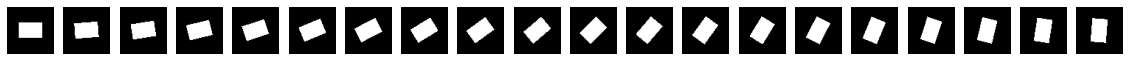

Image shape Start image 1 Channels: torch.Size([1, 1, 64, 64])


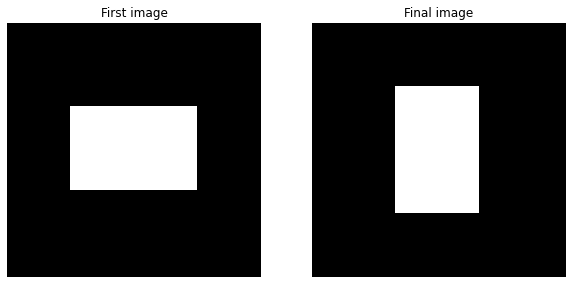

Image statistics:
Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.164062,  Stdev: 0.370377,  Kurtosis: 4.289405
Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.164062,  Stdev: 0.370377,  Kurtosis: 4.289405
(21, 64, 64)


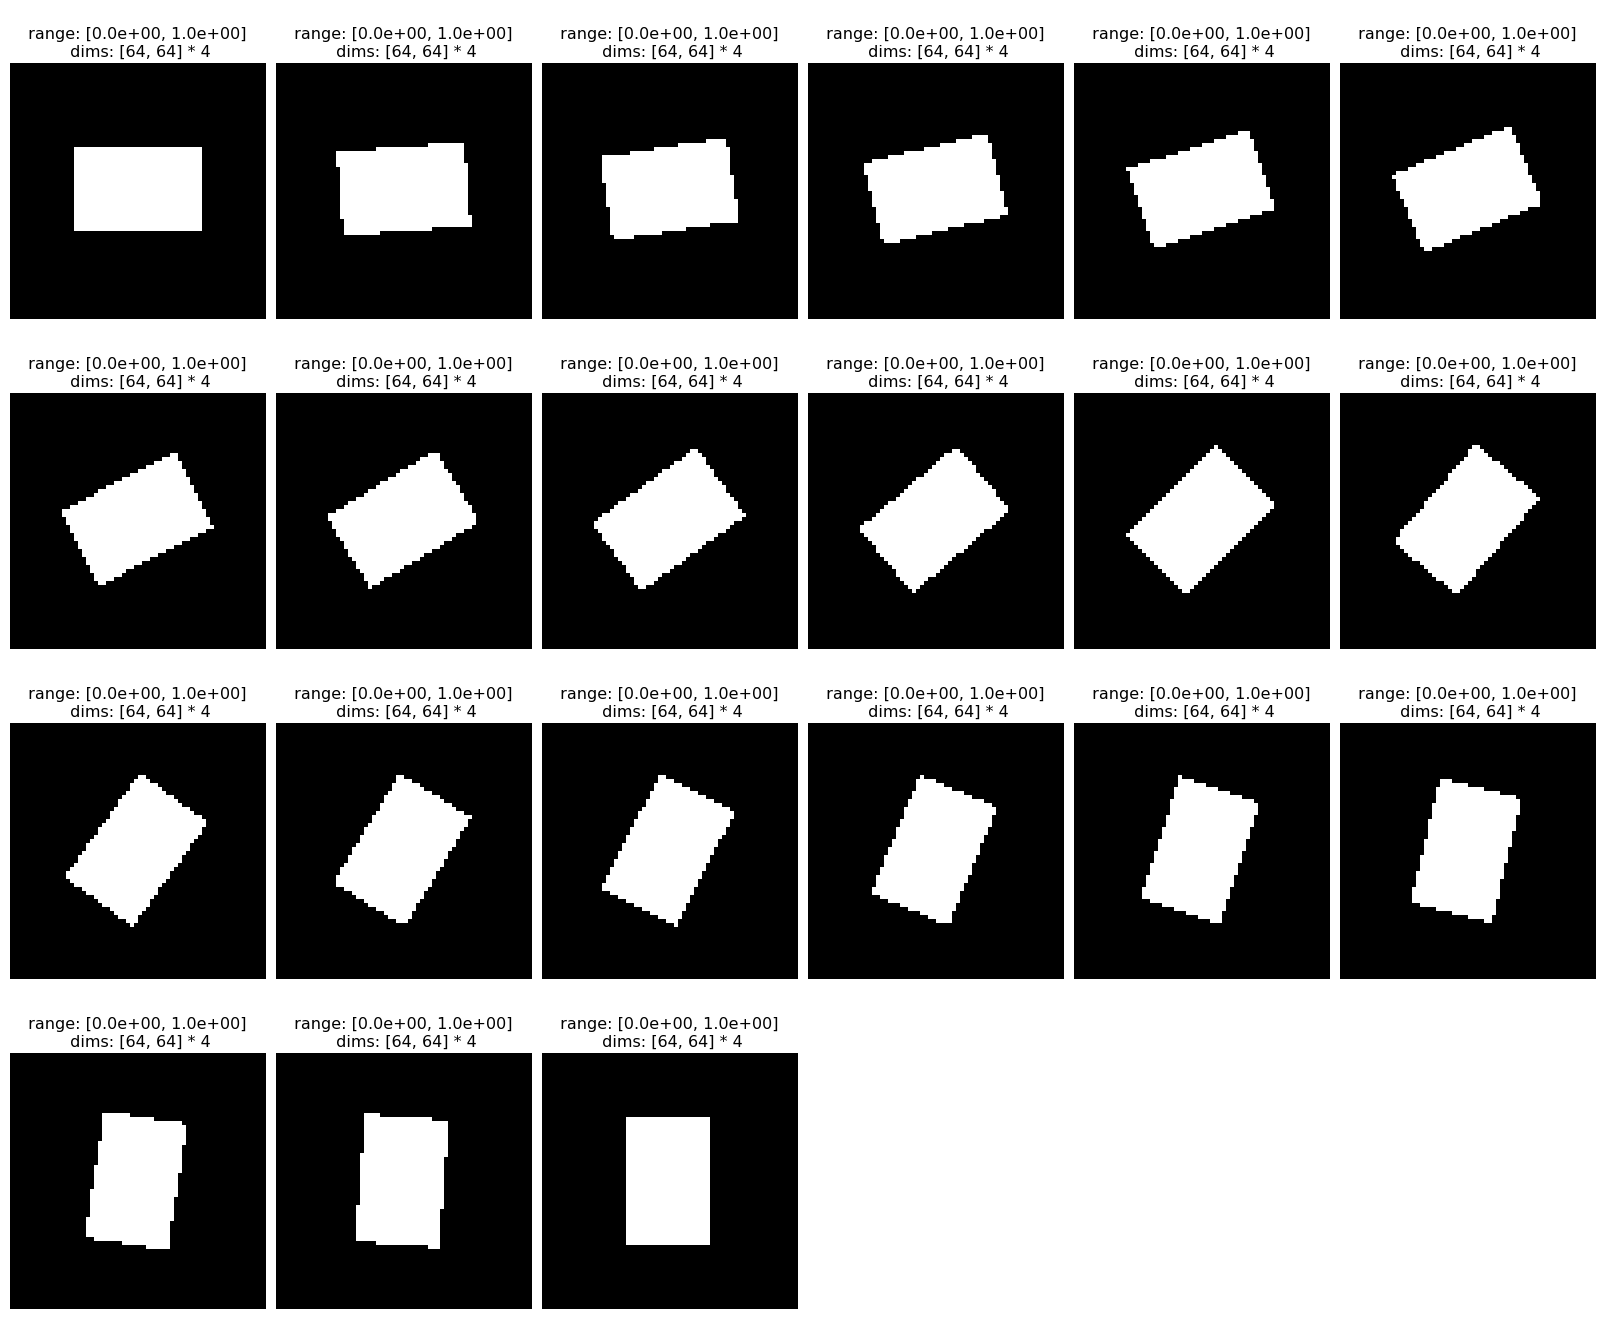

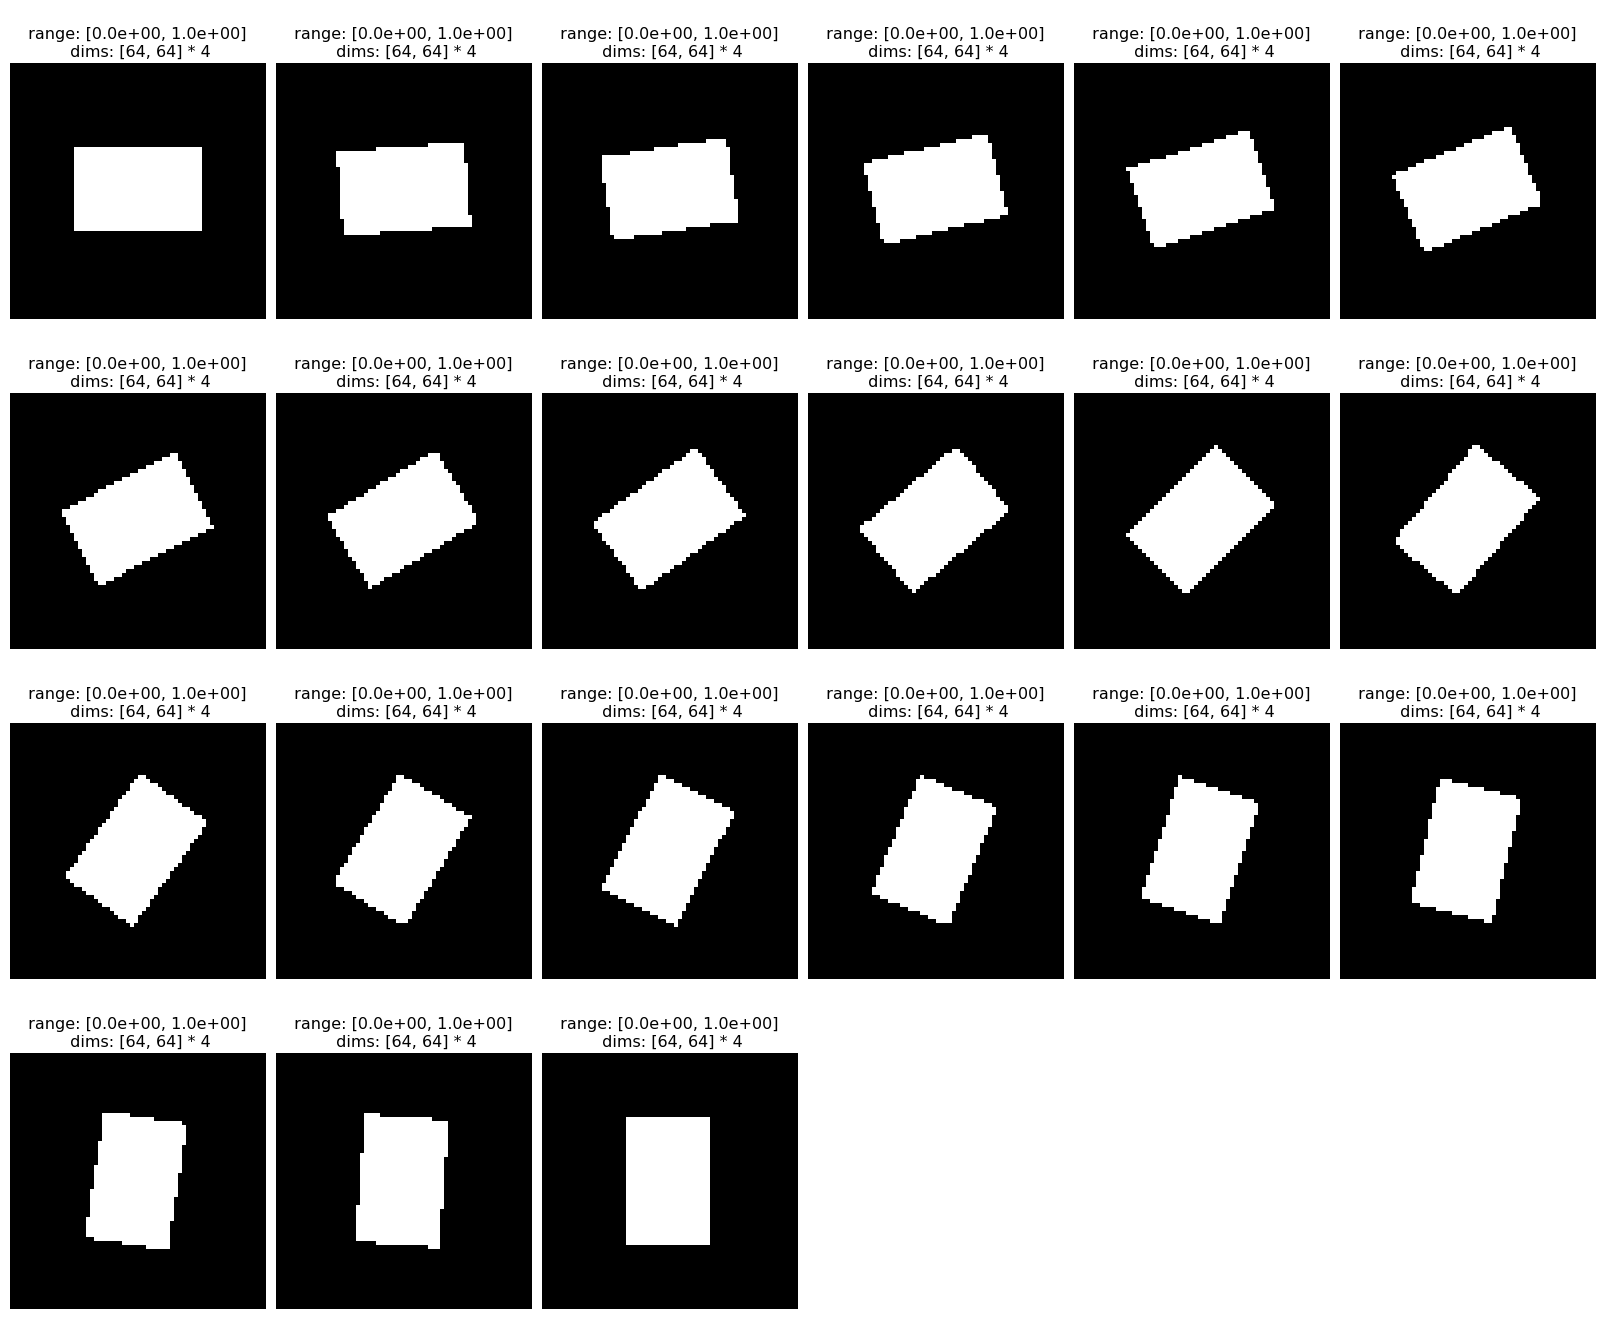

In [2]:
import torchvision.transforms.functional as TF

# Function to create the tensor with a black rectangle in the center
def create_image_tensor(height, width, channels=None):
    if channels is None:
        channels = 1
    else: # 3 channels
        channels  =3
    tensor = torch.zeros((1, channels, height, width))
    rect_height = height // 3
    rect_width = width // 2
    start_row = (height - rect_height) // 2
    start_col = (width - rect_width) // 2
    tensor[:, :, start_row:start_row + rect_height, start_col:start_col + rect_width] = 1
    return tensor

# Function to rotate the tensor and return the rotated tensor
def rotate_image_tensor(image_tensor, angle=90):
    image_pil = TF.to_pil_image(image_tensor.squeeze())
    rotated_image_pil = TF.rotate(image_pil, angle)
    rotated_image_tensor = TF.to_tensor(rotated_image_pil).unsqueeze(0).unsqueeze(0)
    return rotated_image_tensor

# Parameters
# height = 64
# width = 64
# rect_height = height // 3
# rect_width = width // 2
num_steps = 20
final_angle = 90

# Create the initial image tensor
image_tensor = create_image_tensor(height=64, width=64)

# Generate the sequence of rotated images
def create_sequence_rotated_images(image_tensor,num_steps=20, final_angle=90):
    angles=np.linspace(0, final_angle, num_steps+1)
    rotated_images = [rotate_image_tensor(image_tensor, angle) for angle in angles] 
    # create a batch of tensors with shape [num_steps, 1, 1, height, width]
    rotated_images_tensor = torch.cat(rotated_images, dim=0).squeeze(1)
    vid = po.tools.rescale(rotated_images_tensor, 0, 1)
    return vid, rotated_images_tensor

# create a batch of tensors with shape [num_steps, 1, 1, height, width]
vid, rotated_images_tensor = create_sequence_rotated_images(image_tensor,num_steps, final_angle)
#print shape  
print("Rotated images shape:", rotated_images_tensor.shape)



# Display the sequence of rotated images
fig, axes = plt.subplots(1, num_steps, figsize=(20, 2))
for ax, rotated_image in zip(axes, rotated_images_tensor):
    ax.imshow(rotated_image.squeeze(), cmap='gray')
    ax.axis('off')

plt.show()


# blackwhite
# define first and final image of sequence
imgA = vid[0].unsqueeze(0)
# print shape
print("Image shape Start image 1 Channels:", imgA.shape)
imgB = vid[-1].unsqueeze(0)




# display first and final image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(imgA.squeeze(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('First image')
axes[1].imshow(imgB.squeeze(), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Final image')
plt.show()

# print image stats
print("Image statistics:")
pt.image_stats(to_numpy(imgA))
pt.image_stats(to_numpy(imgB))
video = to_numpy(vid).squeeze()
print(video.shape)
pt.imshow(list(video.squeeze()), zoom=4, col_wrap=6)


### Spectral models
Computing a geodesic to reveal excess invariance of the global Fourier magnitude representation.

In [3]:
import torch.fft
class Fourier(nn.Module):
    def __init__(self, representation = 'amp'):
        super().__init__()
        self.representation = representation
        
    def spectrum(self, x):
        return torch.fft.rfftn(x, dim=(2, 3))

    def forward(self, x):
        if self.representation == 'amp':
            return torch.abs(self.spectrum(x))
        elif self.representation == 'phase':
            return torch.angle(self.spectrum(x))
        elif self.representation == 'rectangular':
            return self.spectrum(x)
        elif self.representation == 'polar':
            return torch.cat((torch.abs(self.spectrum(x)),
                              torch.angle(self.spectrum(x))),
                             dim=1)

model = Fourier('amp')
# model = Fourier('polar') # note: need pytorch>=1.8 to take gradients through torch.angle 

In [4]:
# n_steps = len(video)-1
# loss_types = ['l1', 'l2']
# geodesics = {}
# optims = {}


def synthesize_geodesics(imgA:torch.Tensor, imgB:torch.Tensor,model,n_steps=20, loss_types=['l1', 'l2'], geodesics={}, optims={}, initial_sequence='bridge'):
    # Check devices of inputs and model
    print(f"imgA device: {imgA.device}")
    print(f"imgB device: {imgB.device}")
    #print(f"Model device: {model.device}")
    #print(f"Model device: {next(model.parameters()).device}")
    # move all to the same device
    imgA = imgA.to(device)
    imgB = imgB.to(device)
    #model = model.to(device)
    # Create the Geodesic object for each loss type

    for loss_type in loss_types:
    # Generate the name for the Geodesic object based on the loss type
        geodesic_name = f'moog_{loss_type}'
        geodesics[geodesic_name] = po.synth.Geodesic(imgA, imgB, model, n_steps,initial_sequence=initial_sequence, loss_type=loss_type)
    #geodesic_name = po.synth.Geodesic(imgA, imgB, model, n_steps, initial_sequence='bridge', loss_type=loss_type)
        optims[geodesic_name] = torch.optim.Adam([geodesics[geodesic_name]._geodesic], lr=.01, amsgrad=True)
        geodesics[geodesic_name].synthesize(max_iter=500, optimizer=optims[geodesic_name], store_progress=True)
    return geodesics, optims



In [5]:
geodesics, optims = synthesize_geodesics(model=model, imgA=imgA, imgB=imgB)


imgA device: cpu
imgB device: cpu

 Stop criterion for pixel_change_norm = 1.81450e-02


/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:178: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

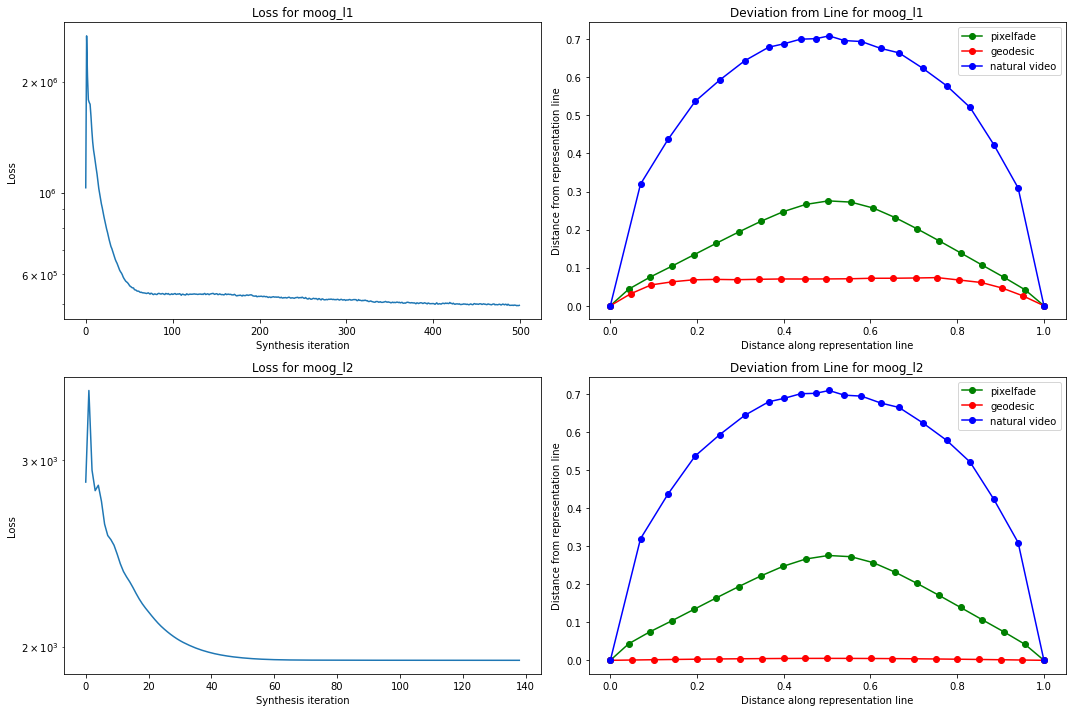

In [ ]:
def plot_loss_and_deviation(model,n_steps=20, loss_types=['l1', 'l2'], geodesics={}):
    # Number of loss types
    num_loss_types = len(loss_types)

# Create a figure with subplots - two plots for each loss type (loss and deviation)
    fig, axes = plt.subplots(nrows=num_loss_types, ncols=2, figsize=(15, 5 * num_loss_types))

# Check if there is only one type to adjust the indexing
    if num_loss_types == 1:
        axes = [axes]  # This makes indexing consistent below

    for i, (key, geodesic) in enumerate(geodesics.items()):
    # `key` would be 'moog_l1', 'moog_l2', etc.
    # Plot loss on the first column of the current row
        po.synth.geodesic.plot_loss(geodesic, ax=axes[i][0])
        axes[i][0].set_title(f'Loss for {key}')

    # Plot deviation from line on the second column of the current row
        po.synth.geodesic.plot_deviation_from_line(geodesic, vid, ax=axes[i][1])
        axes[i][1].set_title(f'Deviation from Line for {key}')

    plt.tight_layout()
    plt.show()

plot_loss_and_deviation(geodesics=geodesics, model=model)    

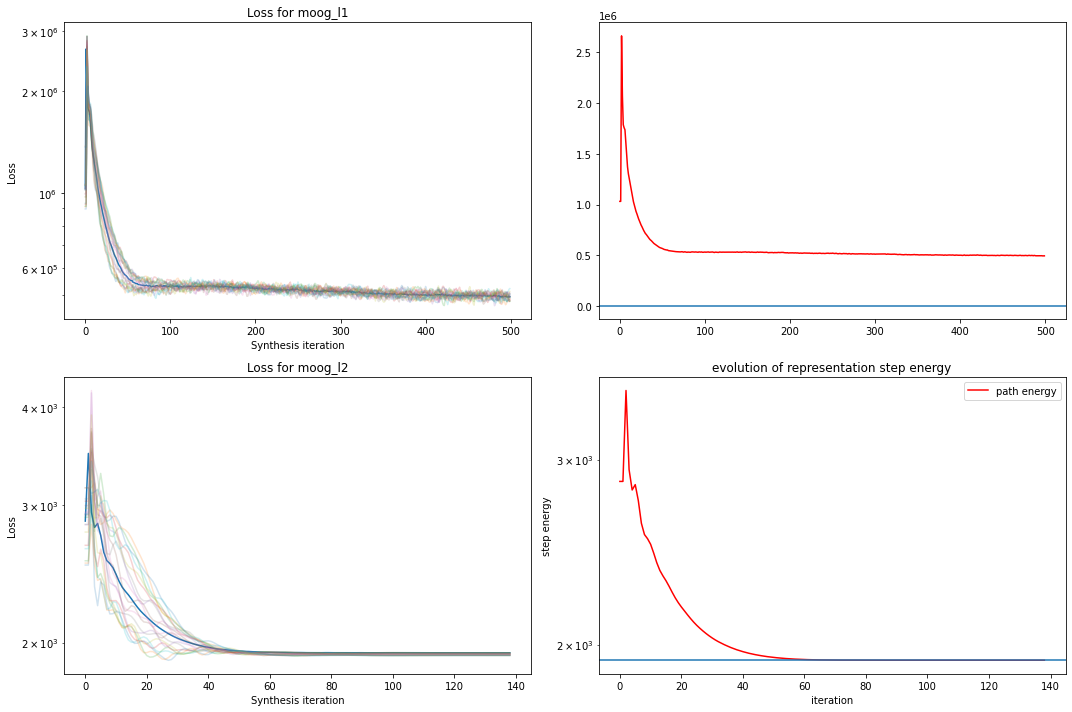

In [ ]:
def plot_loss_and_evolution( geodesics={}, loss_types=['l1', 'l2']):
    num_loss_types = len(loss_types)
    fig, axes = plt.subplots(nrows=num_loss_types, ncols=2, figsize=(15, 5 * num_loss_types))

# Check if there is only one type to adjust the indexing
    if num_loss_types == 1:
        axes = [axes]  # This makes indexing consistent below

    for i, (key, geodesic) in enumerate(geodesics.items()):
    # `key` would be 'moog_l1', 'moog_l2', etc.
    # Plot loss on the first column of the current row
        po.synth.geodesic.plot_loss(geodesic, ax=axes[i][0])
        axes[i][0].plot(po.to_numpy(geodesic.step_energy), alpha=.2)
        axes[i][0].set_title(f'Loss for {key}')
    # plot the path energy in the second column of the current row
        axes[i][1].plot(geodesic.step_energy.mean(1), 'r-', label='path energy')
        axes[i][1].axhline(torch.linalg.vector_norm(geodesic.model(geodesic.image_a) - geodesic.model(geodesic.image_b), ord=2) ** 2 / geodesic.n_steps ** 2)


    plt.legend()
    plt.title('evolution of representation step energy')
    plt.ylabel('step energy')
    plt.xlabel('iteration')
    plt.yscale('log')


    plt.tight_layout()
    plt.show()

plot_loss_and_evolution(geodesics=geodesics)

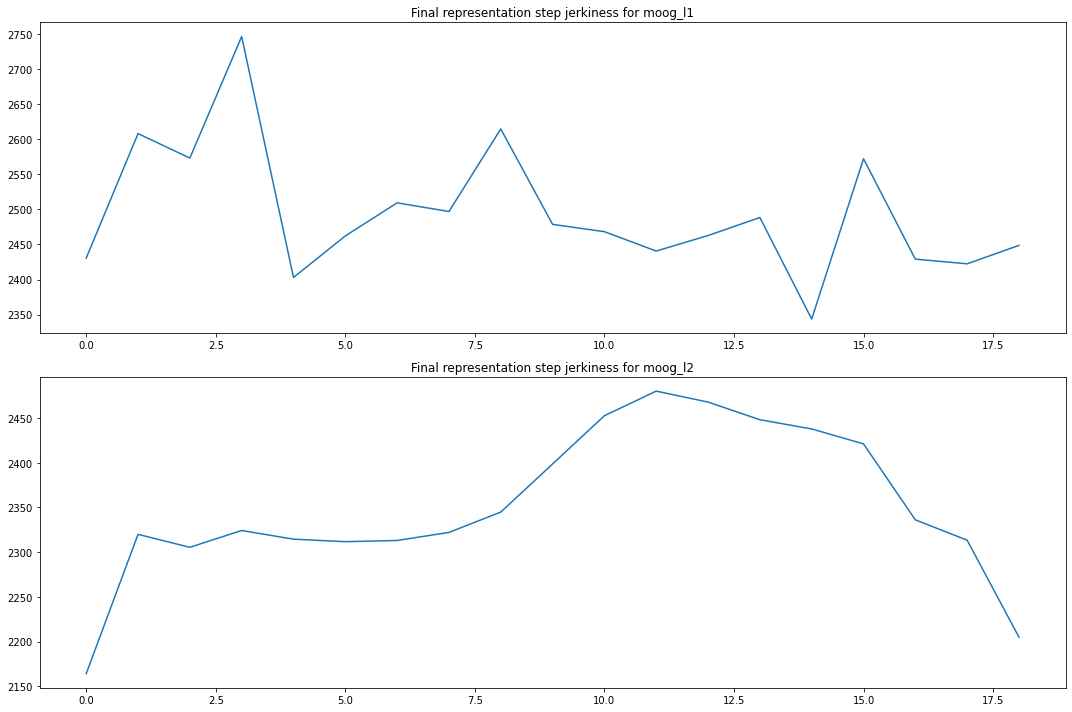

In [ ]:
def plot_jerkiness( loss_types=['l1', 'l2'], geodesics={}):
    num_loss_types = len(loss_types)
    fig, axes = plt.subplots(nrows=num_loss_types, ncols=1, figsize=(15, 5 * num_loss_types))

# Check if there is only one type to adjust the indexing
    if num_loss_types == 1:
        axes = [axes]  # This makes indexing consistent below

    for i, (key, geodesic) in enumerate(geodesics.items()):
    # `key` would be 'moog_l1', 'moog_l2', etc.
        axes[i].plot(geodesic.calculate_jerkiness().detach())
        axes[i].set_title(f'Final representation step jerkiness for {key}')

    plt.tight_layout()
    plt.show()

plot_jerkiness(geodesics=geodesics)


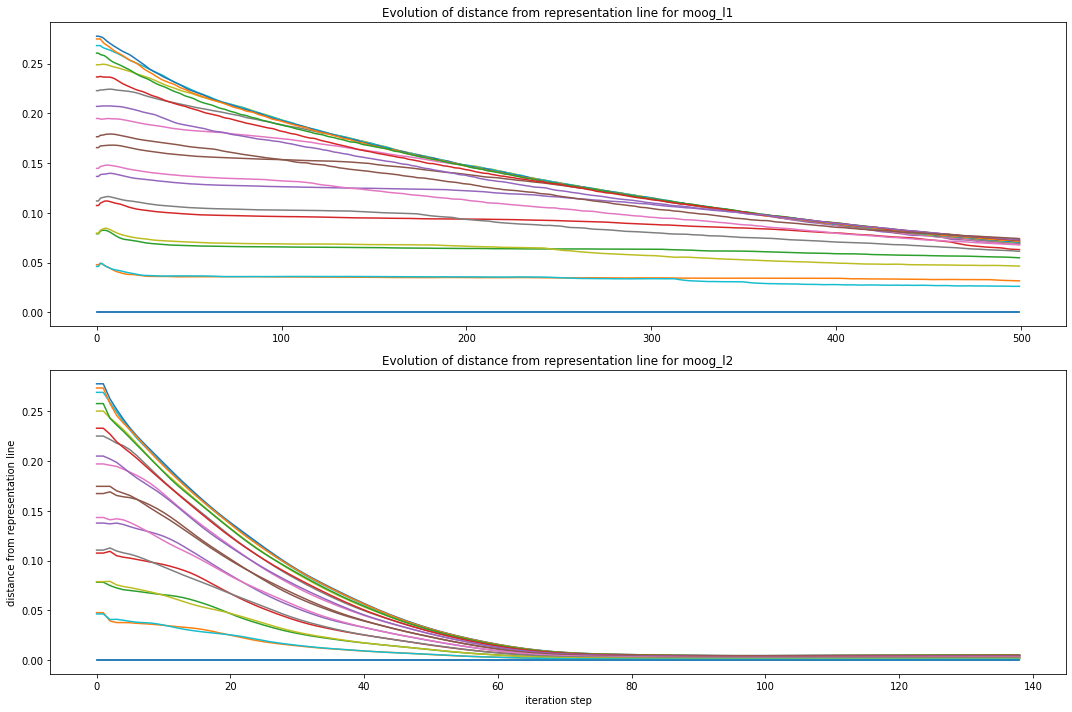

In [ ]:
def dist_from_representation( loss_types=['l1', 'l2'], geodesics={}):
    num_loss_types = len(loss_types)
    fig, axes = plt.subplots(nrows=num_loss_types, ncols=1, figsize=(15, 5 * num_loss_types))

# Check if there is only one type to adjust the indexing
    if num_loss_types == 1:
        axes = [axes]  # This makes indexing consistent below

    for i, (key, geodesic) in enumerate(geodesics.items()):
    # `key` would be 'moog_l1', 'moog_l2', etc.
        axes[i].plot(po.to_numpy(geodesic.dev_from_line[..., 1]))
        axes[i].set_title(f'Evolution of distance from representation line for {key}')

    plt.ylabel('distance from representation line')
    plt.xlabel('iteration step')

    plt.tight_layout()
    plt.show()

dist_from_representation(geodesics=geodesics)

Top: l1
 Bottom: l2


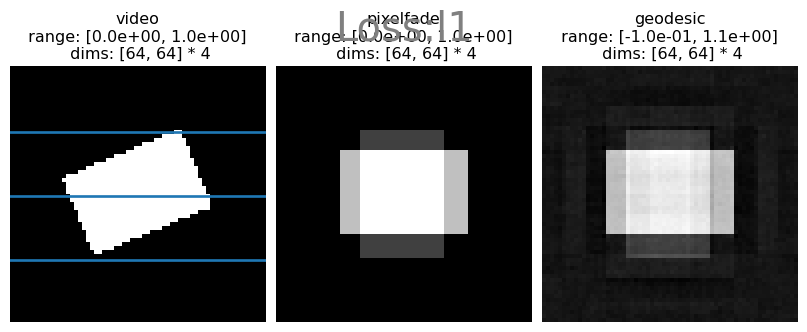

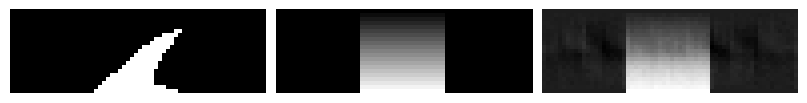

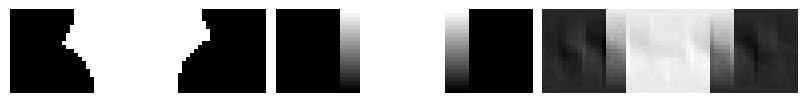

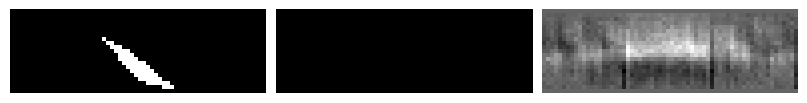

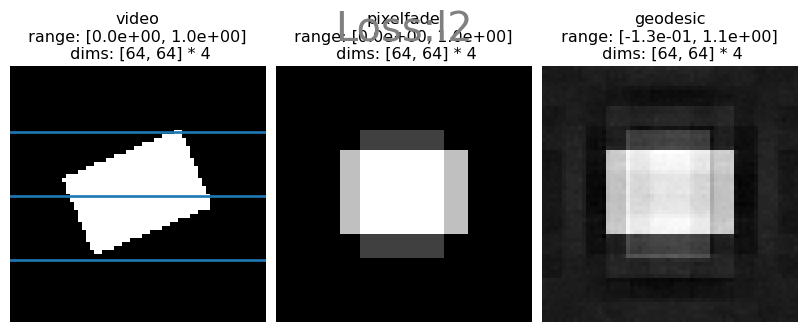

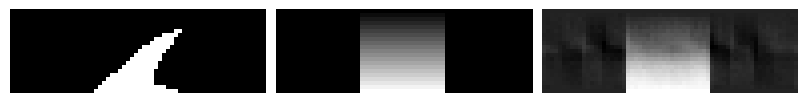

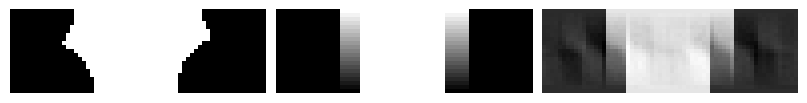

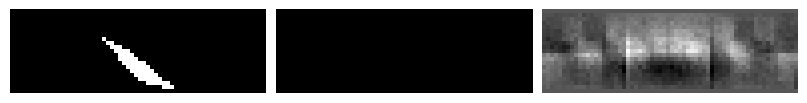

In [ ]:
def plot_invariances(video, geodesics={}, loss_types=['l1', 'l2']  ):
    pixelfade = {}
    geodesic_np = {}

    print(f"Top: {loss_types[0]}\n Bottom: {loss_types[1]}" )
    for i, loss_type in enumerate(geodesics.keys()):
    # fill pixelfade and geodesic dictionaries

        pixelfade[loss_type] = to_numpy(geodesics[loss_type].pixelfade.squeeze())
        geodesic_np[loss_type] = to_numpy(geodesics[loss_type].geodesic.squeeze())
    #print(f"loss: " , loss_type)
        fig = pt.imshow([video[5], pixelfade[loss_type][5], geodesic_np[loss_type][5]],
          title=['video', 'pixelfade', 'geodesic'],
          col_wrap=3, zoom=4)
        fig.subplots_adjust(top=1.8)
        fig.suptitle('Loss:' + loss_types[i], fontsize=30, color='gray')
        size = geodesic_np[loss_type].shape[-1]

    # for image slices
        h, m, l = (size // 2 + size // 4, size // 2, size // 2 - size // 4)


    # Plot for different horizontal lines in new figures
        a = fig.get_axes()[0]
        for line in (h, m, l):
            a.axhline(line, lw=2)

   

        pt.imshow([video[:, l], pixelfade[loss_type][:, l], geodesic_np[loss_type][:, l]],
            title=None, col_wrap=3, zoom=4)
        pt.imshow([video[:, m], pixelfade[loss_type][:, m], geodesic_np[loss_type][:, m]],
            title=None, col_wrap=3, zoom=4)
        pt.imshow([video[:, h], pixelfade[loss_type][:, h], geodesic_np[loss_type][:, h]],
            title=None, col_wrap=3, zoom=4)

plot_invariances(geodesics=geodesics, video=video)

Blue: L2 > L1, Red: L1 > L2


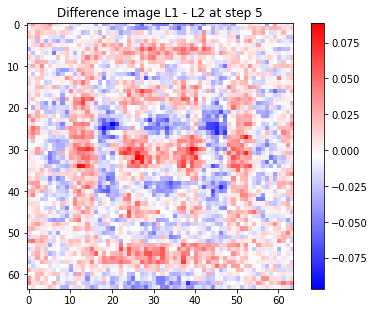

In [ ]:
def visualize_difference_image(geodesics={}, nth_step=5):
    geodesic_np = {}
    for g in geodesics.items():
    # fill pixelfade and geodesic dictionaries
        loss_type = g[0]
        #geodesic = g[1]

        geodesic_np[loss_type] = to_numpy(geodesics[loss_type].geodesic.squeeze())
#  difference image between the L1 and L2 geodesic at some number of steps
    diff = geodesic_np["moog_l1"][nth_step] - geodesic_np["moog_l2"][nth_step]
    # Interpretation
    print("Blue: L2 > L1, Red: L1 > L2")
# plot the difference image
    plt.imshow(diff, cmap='bwr')
    plt.colorbar()
    plt.title('Difference image L1 - L2 at step ' + str(nth_step))

visualize_difference_image(geodesics=geodesics)

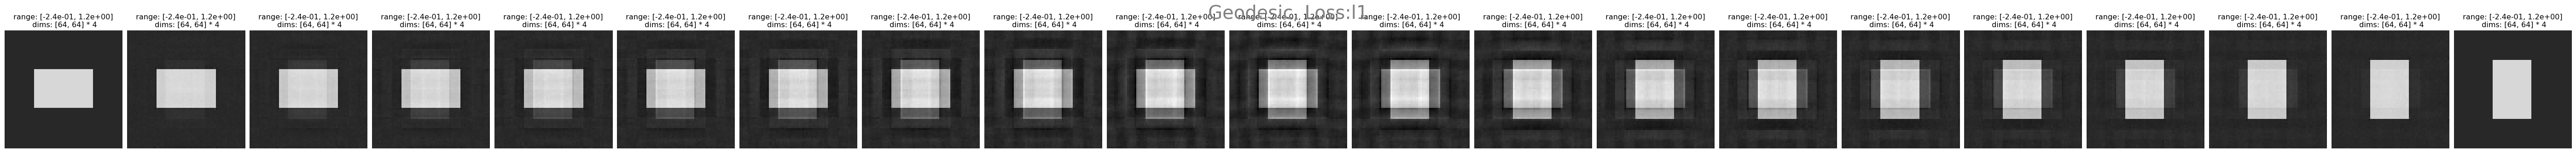

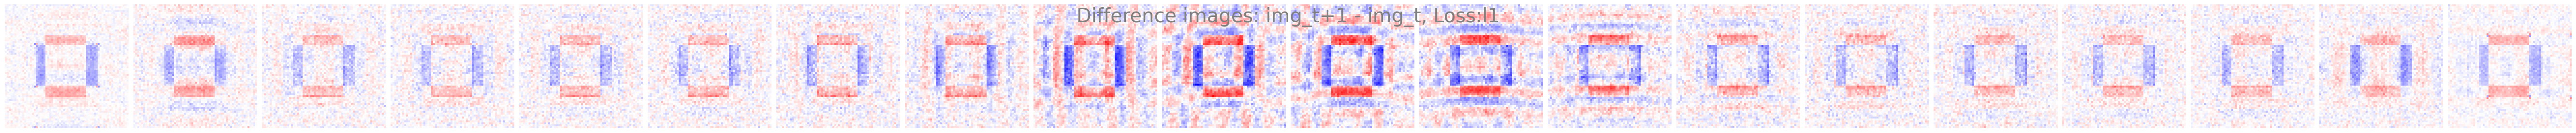

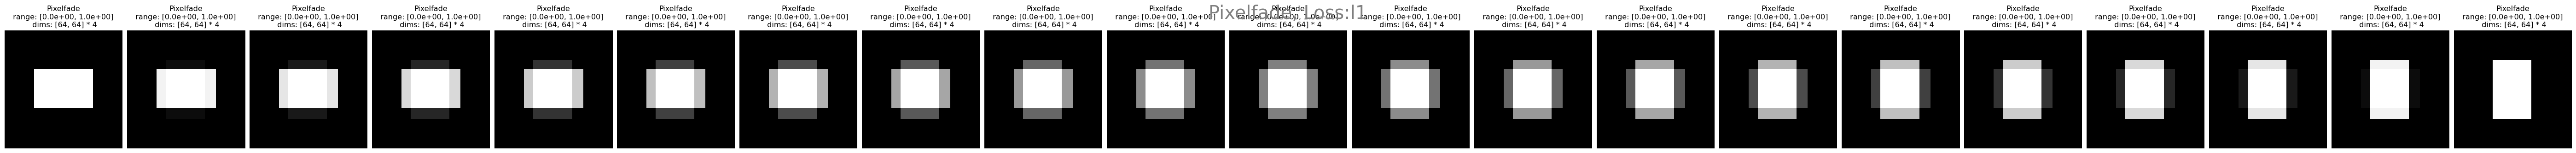

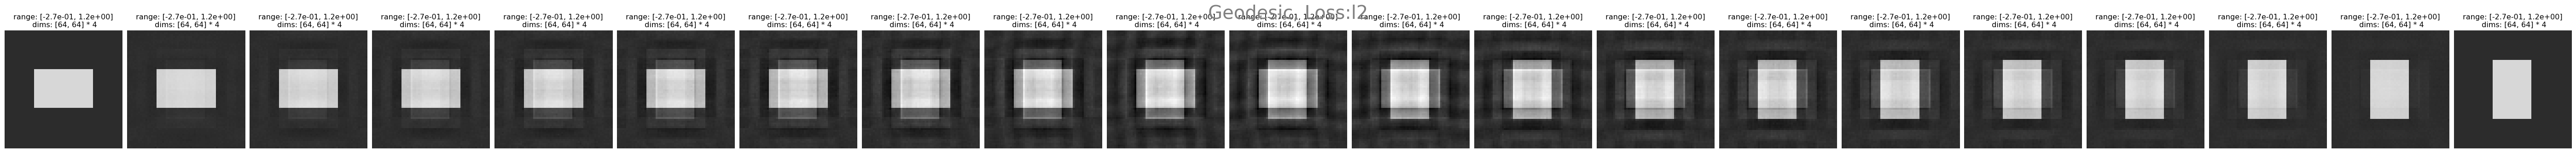

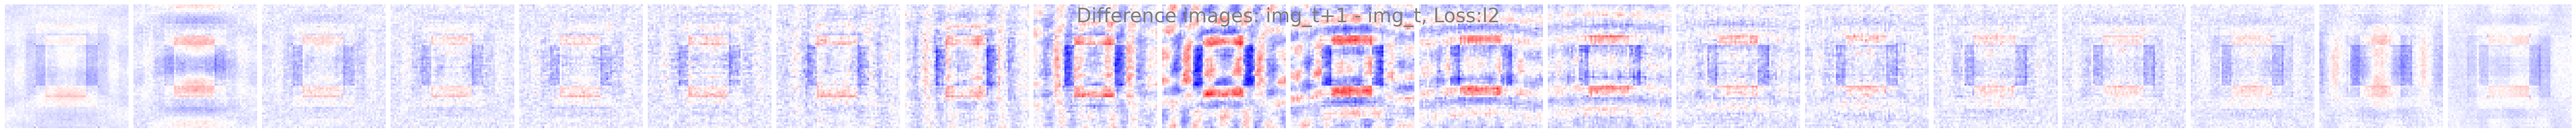

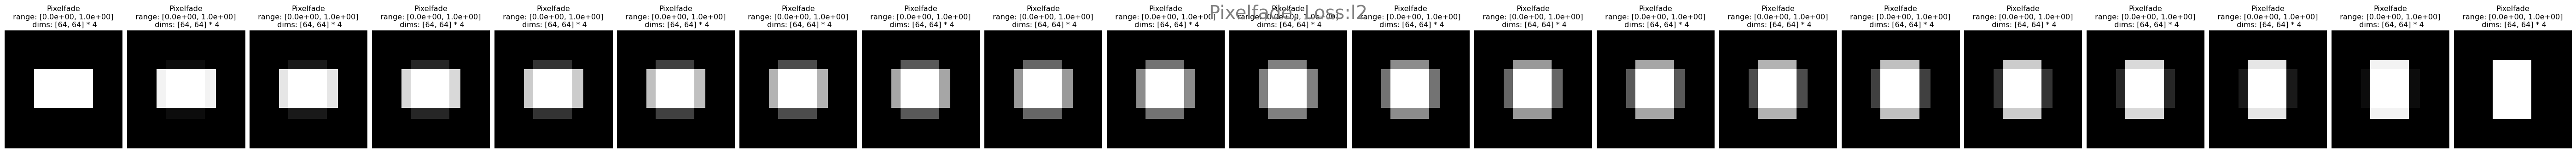

In [ ]:
def visualize_geodesics(loss_types=['l1', 'l2'], geodesics={}):
    for i, loss_type in enumerate(geodesics.keys()):
        fig = pt.imshow(list(geodesics[loss_type].geodesic.detach().squeeze()), vrange='auto1', zoom=4)
        fig.subplots_adjust(top=0.8)
        fig.suptitle('Geodesic, Loss:' + loss_types[i], fontsize=30, color='gray')
        tensor_diffs = geodesics[loss_type].geodesic[1:] - geodesics[loss_type].geodesic[0:-1] 
        fig = pt.imshow(list(tensor_diffs.detach().squeeze()), cmap='bwr', vrange='auto1', zoom=4, title=None)
        fig.suptitle('Difference images: img_t+1 - img_t, Loss:' + loss_types[i], fontsize=30, color='gray')
    
        fig = pt.imshow(list(geodesics[loss_type].pixelfade.detach().squeeze()), vrange='auto1', title='Pixelfade', zoom=4)
        fig.suptitle('Pixelfade, Loss:' + loss_types[i], fontsize=30, color='gray')

visualize_geodesics(geodesics=geodesics)



### Physiologically inspired models

/mnt/home/hdettki/code/plenoptic/src/plenoptic/simulate/models/frontend.py:388: UserWarning: pretrained is True but cache_filt is False. Set cache_filt to True for efficiency unless you are fine-tuning.
  warn("pretrained is True but cache_filt is False. Set cache_filt to "


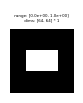

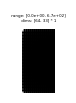

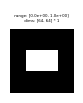

In [ ]:
model_onoff = po.simul.OnOff(kernel_size=(31,31), pretrained=True)
po.tools.remove_grad(model_onoff)
po.imshow(model(imgA))
po.imshow(imgA)

In [ ]:
n_steps = 10
print(imgA.shape)
#moog = po.synth.Geodesic(imgA, imgB, model, n_steps, initial_sequence='bridge', loss_type='l2')
# create the same plots for new model as for Fourier


geodesics_onoff, optims_onoff = synthesize_geodesics(imgA=imgA, imgB=imgB, model=model_onoff, n_steps=n_steps)


torch.Size([1, 1, 64, 64])

 Stop criterion for pixel_change_norm = 1.31745e-02


/mnt/home/hdettki/.virtualenvs/plenoptic/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/500 [00:00<?, ?it/s]


 Stop criterion for pixel_change_norm = 1.31745e-02


  0%|          | 0/500 [00:00<?, ?it/s]

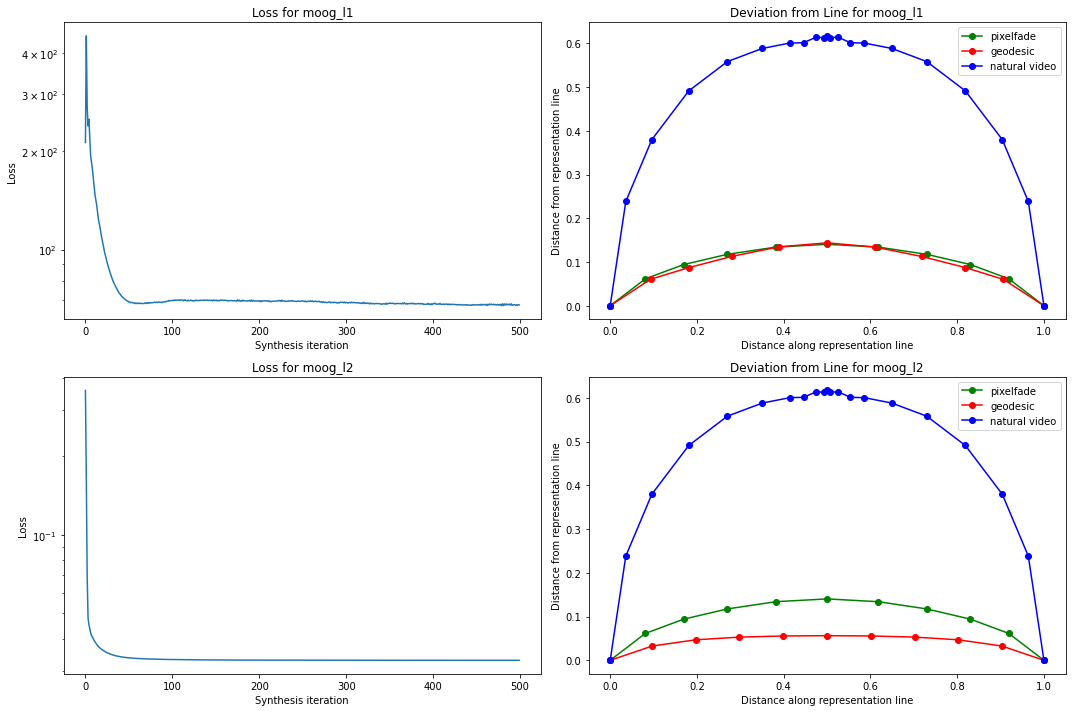

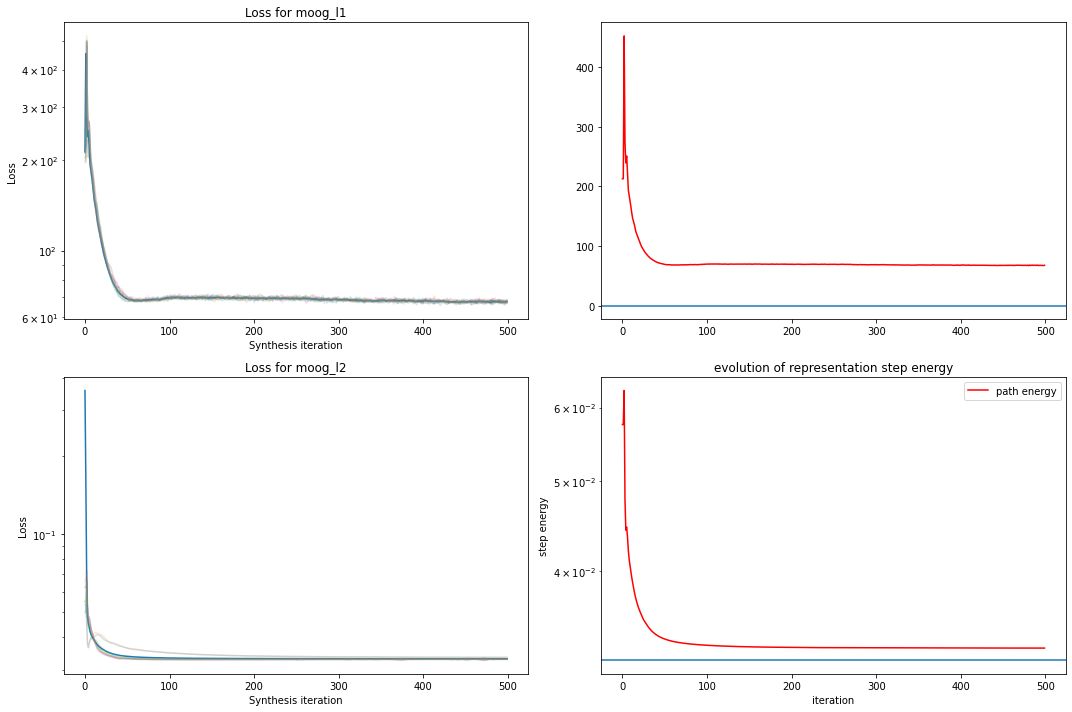

In [ ]:
# create same plots for new model as for Fourier
plot_loss_and_deviation( model=model_onoff, geodesics=geodesics_onoff)
plot_loss_and_evolution(geodesics_onoff)
#plot_jerkiness(geodesics_onoff)
#plotInvariances(geodesics_onoff)
#visualize_difference_image(geodesics_onoff)


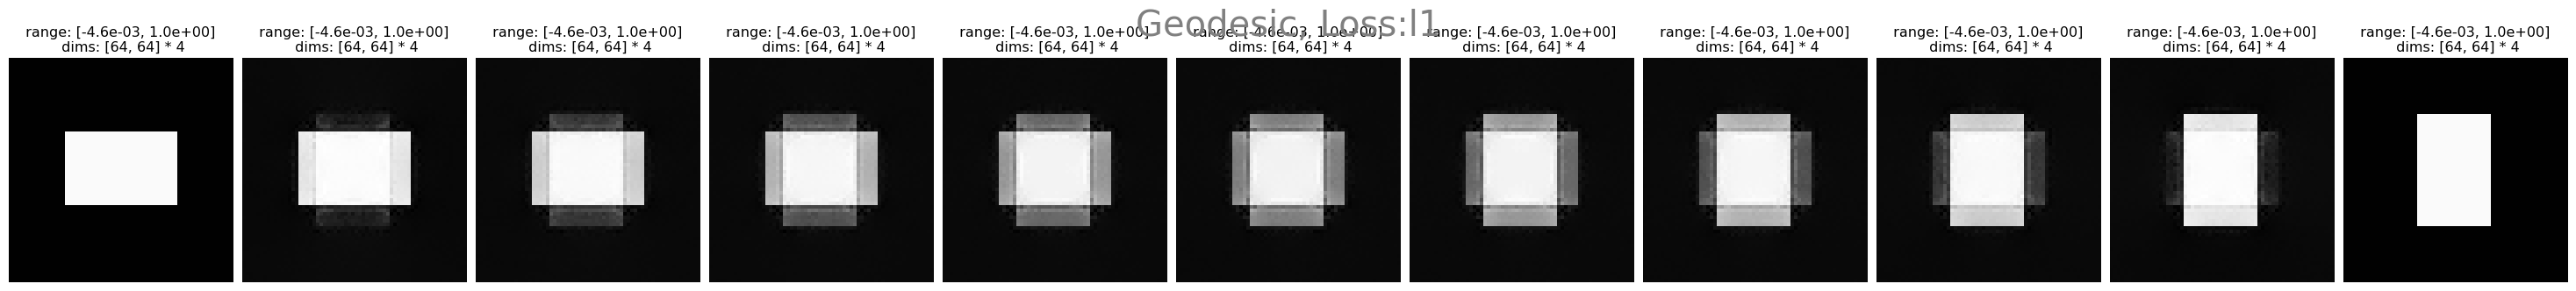

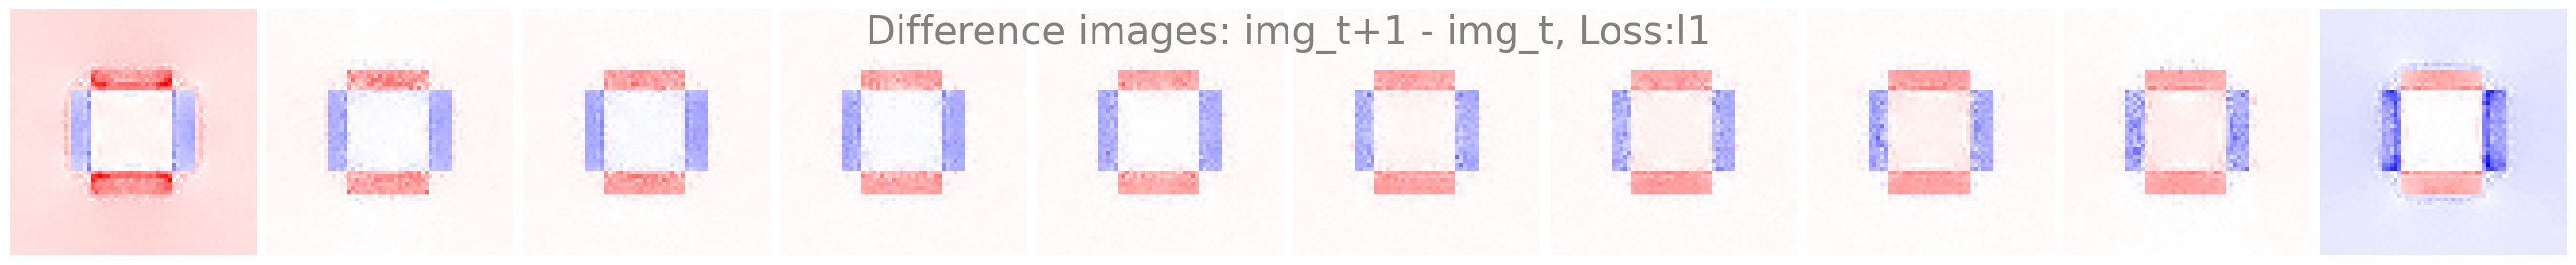

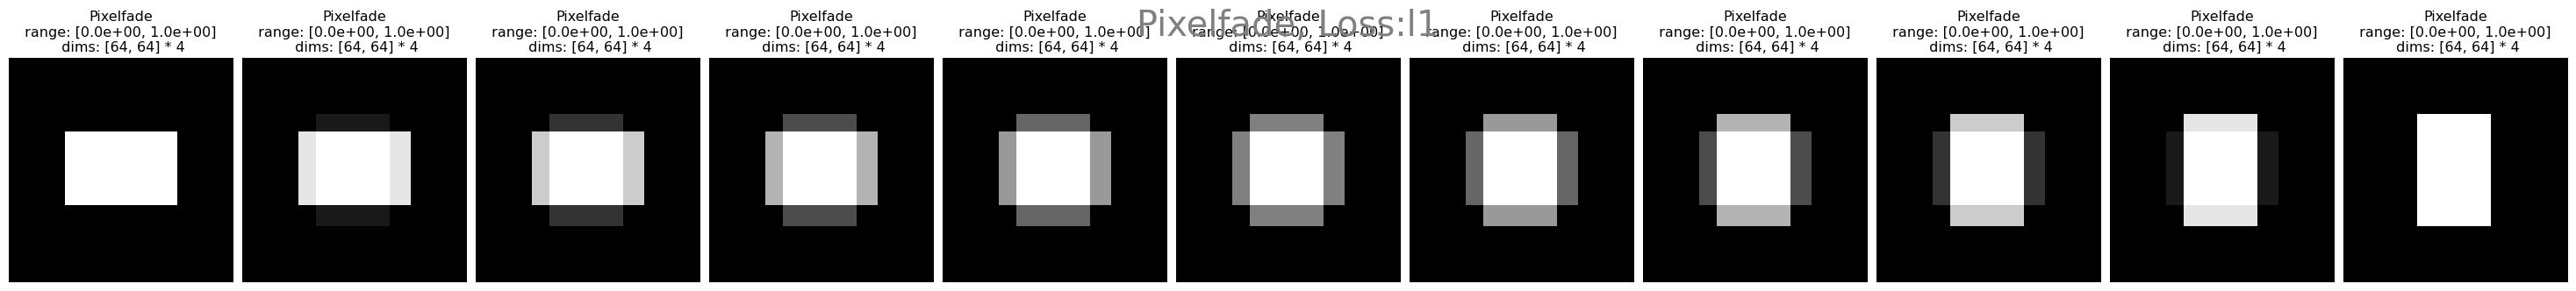

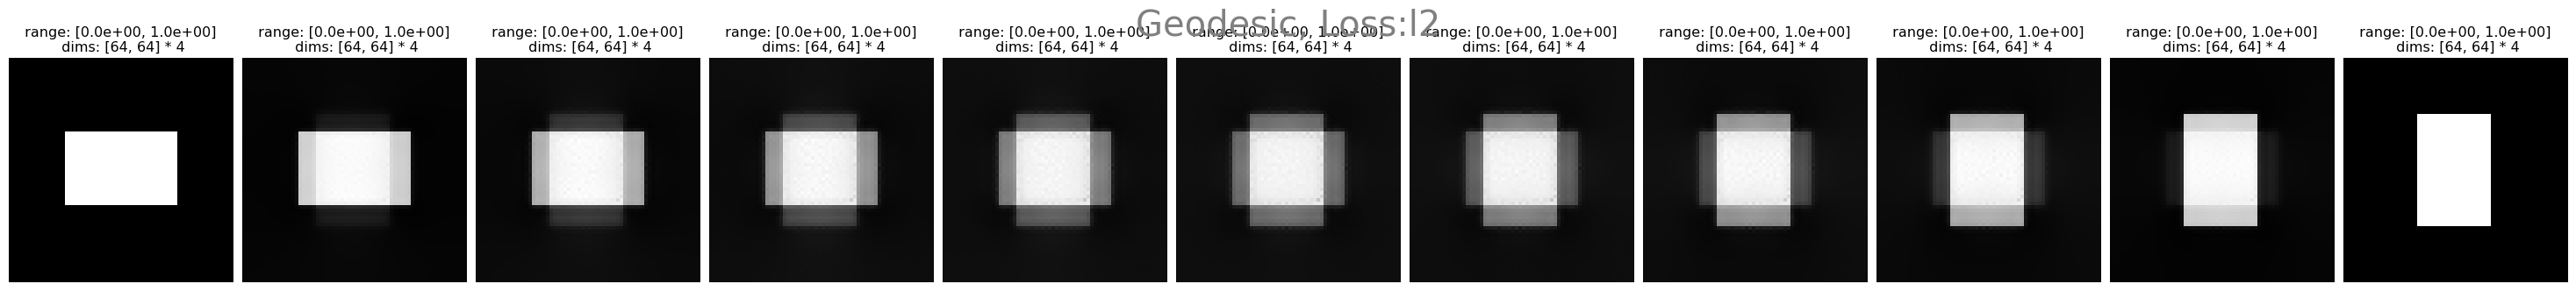

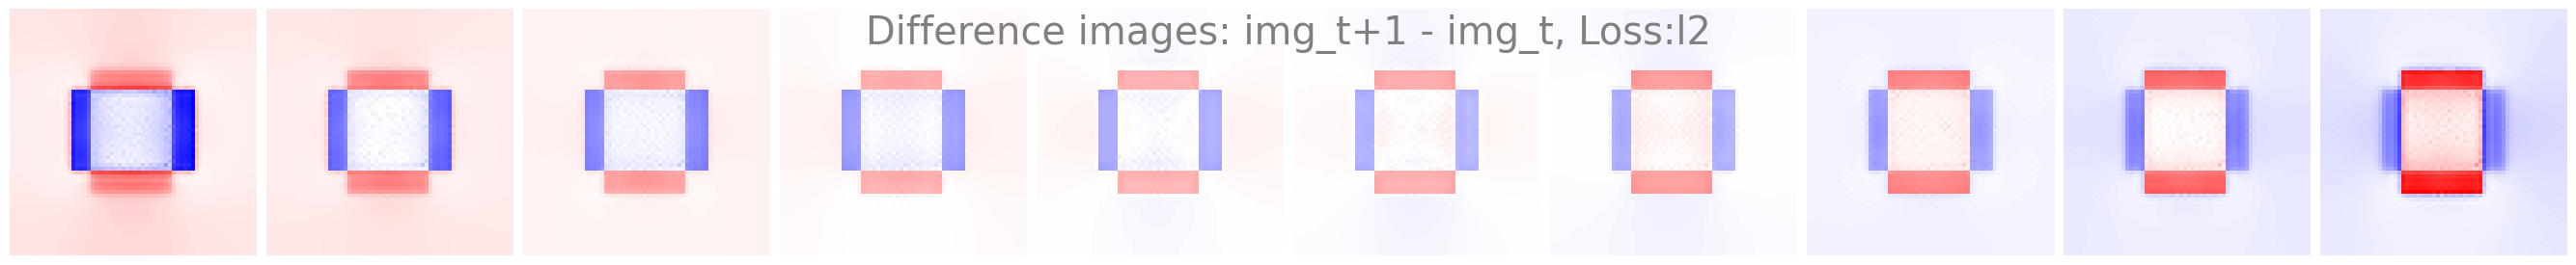

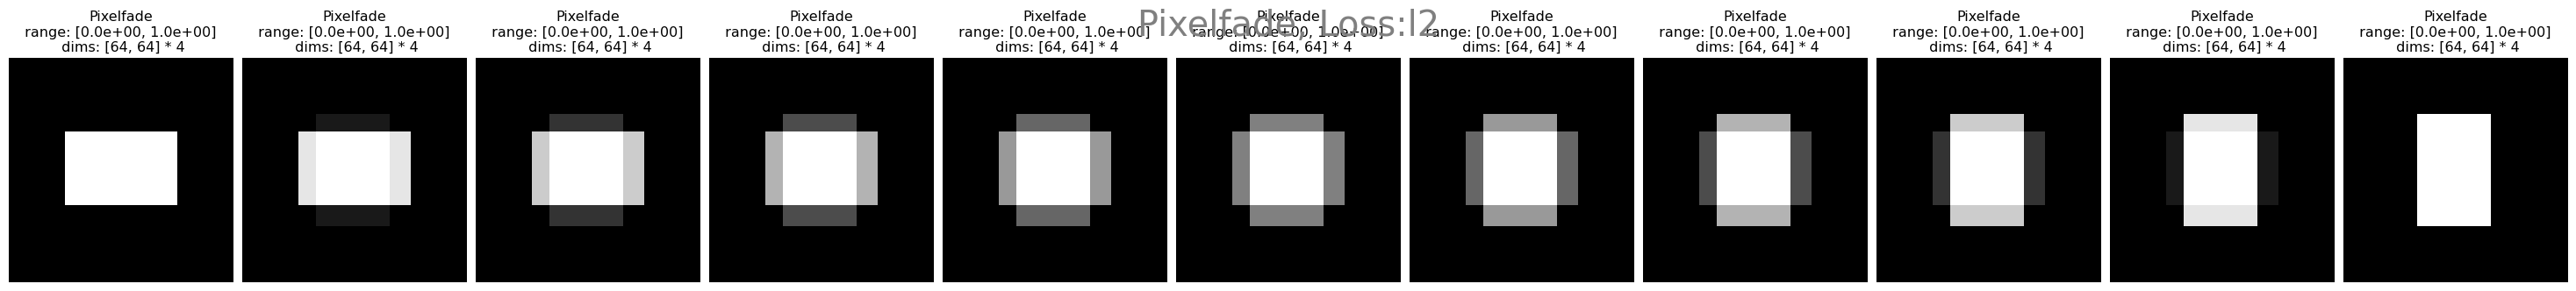

In [ ]:
visualize_geodesics(geodesics=geodesics_onoff)

## vgg16: rotation

In [ ]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network as used in the paper 
weights = VGG16_Weights.DEFAULT
vgg_model_original = vgg16(weights=weights)
vgg_model_original.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freezing the base model and cutting of the final layer

In [ ]:
vgg_model_original.requires_grad_(False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Dropping the final layer
We don't want to classify our images, so let's drop all layers starting from the final layer to the penultimate linear layer.

In [ ]:
import copy
torch.manual_seed(17)
# copy the vgg model and remove the last layer
# b
# vgg_model = copy.deepcopy(vgg_model_original)
# # replace the final layer with an identiy layer
# #vgg_model.classifier[-1] = nn.Identity()
# # drop the final three layers of the network


# # Load the pretrained VGG16 model
# vgg_model = models.vgg16(pretrained=True)

# # Remove the last three layers (ReLU, Dropout, and the final fully connected layer)
# vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-3])



# vgg_model.classifier = vgg_model.classifier[:-3] # we don't want the last three layers (relu, dropout, and fc)
# vgg_model.to(device)
# Print the final layer of the VGG model
# print("Final layer of VGG model:")
# print(vgg_model.classifier[-1])
# # print the shape of the final layer
# print("Final layer shape:")
# print(vgg_model.classifier[-1].out_features)

In [ ]:
# Load the pretrained VGG16 model
vgg_model = models.vgg16(pretrained=True)
vgg_model.requires_grad_(False)
vgg_model = vgg_model.to(device)

# Remove the last three layers (ReLU, Dropout, and the final fully connected layer)
vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-3])

# Add a custom layer to reshape the output to match the expected dimensions
class CustomVGG16(nn.Module):
    def __init__(self, original_model):
        super(CustomVGG16, self).__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool
        self.classifier = nn.Sequential(
            *list(original_model.classifier.children())[:-3]
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the output
        x = self.classifier(x)
        x = x.view(x.size(0), -1, 1, 1)  # Reshape to (batch_size, 4096, 1, 1)
        return x


for param in custom_vgg_model.parameters():
    param.requires_grad = False
# Create an instance of the custom model
custom_vgg_model = CustomVGG16(vgg_model).to(device)
# turn gradient off


print(f"Model device: {next(custom_vgg_model.parameters()).device}")

/mnt/home/hdettki/.virtualenvs/plenoptic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/home/hdettki/.virtualenvs/plenoptic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model device: cuda:0


In [ ]:
# Create a dummy input to verify the output dimensions
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Get the output of the modified VGG16 model
output = custom_vgg_model(dummy_input)

# Print the output dimensions
print(f"Output dimensions: {output.shape}")  # Expected: (1, 4096, 1, 1)

Output dimensions: torch.Size([1, 4096, 1, 1])


In [ ]:
# create images with 3 channels
img_3c = create_image_tensor(height=224, width=224, channels=3)
vid_3c, rotated_images_tensor_3c = create_sequence_rotated_images(img_3c, num_steps, final_angle)
print("Rotated images shape:", rotated_images_tensor_3c.shape)
#pt.imshow(list(to_numpy(vid_3c).squeeze()), zoom=4, col_wrap=6)
video_3c = to_numpy(vid_3c).squeeze()

imgA_3c = vid_3c[0].unsqueeze(0)
imgB_3c = vid_3c[-1].unsqueeze(0)
print(video_3c.shape)
video_3c_print = np.transpose(video_3c, (0, 2, 3, 1))
print(np.transpose(video_3c, (0, 2, 3, 1)).shape)
#pt.imshow(list(video_3c_print.squeeze()), zoom=4, col_wrap=6)

# send all images to the device
imgA_3c = imgA_3c.to(device)
imgB_3c = imgB_3c.to(device)
vid_3c = vid_3c.to(device)
rotated_images_tensor_3c = rotated_images_tensor_3c.to(device)

imgA_3c.shape

Rotated images shape: torch.Size([21, 3, 224, 224])
(21, 3, 224, 224)
(21, 224, 224, 3)


torch.Size([1, 3, 224, 224])

In [ ]:
# synthesize geodesics for the VGG model
geodesics_vgg , optims_vgg = synthesize_geodesics(imgA=imgA_3c, imgB=imgB_3c, model=custom_vgg_model)

imgA device: cuda:0
imgB device: cuda:0
Model device: cuda:0

 Stop criterion for pixel_change_norm = 1.10459e-01


/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:178: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!